In [1]:
# Useful imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Step 1 : Calibrate Camera

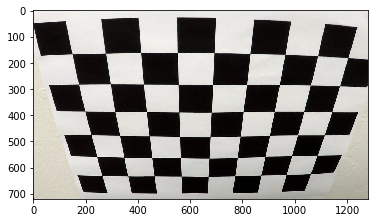

In [2]:
# Visualise checkerboard image
checker_img_path = 'camera_calibration/calibration2.jpg'
checker_img = mpimg.imread(checker_img_path)
plt.imshow(checker_img)

Clearly there are 9 * 6 corner points

In [3]:
# Initialise object points in WCS
obj_pt = np.zeros((9*6,3),np.float32)
obj_pt[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

#Empty array to store the points
object_points = []
image_points = []

#Read image paths
images = glob.glob('camera_calibration/calibration*.jpg')

# Append points
for img_path in images:
    image = cv2.imread(img_path)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
    if ret:
        object_points.append(obj_pt)
        image_points.append(corners)

# Calibrate camera
image_size = (image.shape[1],image.shape[0]) # calibrate camera function needs shape as (width,height)
ret,matrix,dist_coeff,rvecs,tvecs = cv2.calibrateCamera(object_points,image_points,image_size,None,None)
if ret:
    print('Camera calibrated successfully!')
else:
    raise ValueError

Camera calibrated successfully!


### Step 2 : Undistort images

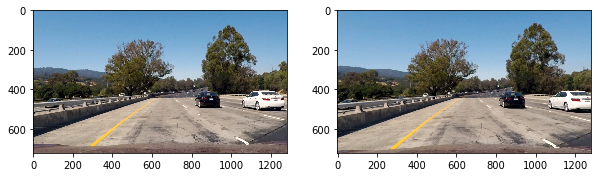

In [4]:
def get_undistorted(img):
    global matrix,dist_coeff
    undistorted = cv2.undistort(img,matrix,dist_coeff,None,matrix)
    return undistorted

# Visualise undistortion
img = cv2.imread('test_images/test1.jpg')
undist_img = get_undistorted(img)
_,(a1,a2) = plt.subplots(1,2,figsize=(10,10))
a1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
a2.imshow(cv2.cvtColor(undist_img,cv2.COLOR_BGR2RGB))
plt.show()

### Step 3 : Perpective Transform

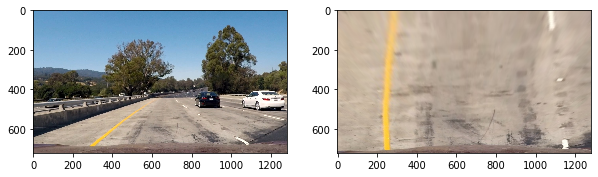

In [5]:
def birds_eye(undist_img):
    img_size = (undist_img.shape[1],undist_img.shape[0])
    # Need 4 points to find perpective transformation
    src = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
    dest = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src,dest)
    bird_eye_img = cv2.warpPerspective(undist_img,M,img_size)
    return bird_eye_img

# Visualise warp
warped = birds_eye(undist_img)
_,(a1,a2) = plt.subplots(1,2,figsize=(10,10))
a1.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
a2.imshow(cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))
plt.show()
    

### Step 5 : Thresholding

From experiments it is found that the combination of thresholds applied to 'L' channel in LUV colorspace and 'B' channel in LAB colorspace yields better results

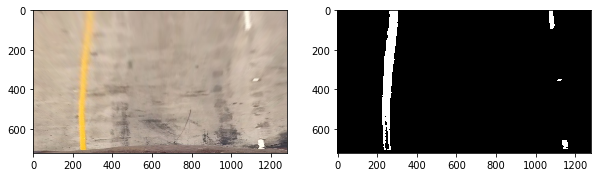

In [6]:
def apply_thresholding(warped_img):
    l_channel = cv2.cvtColor(warped_img, cv2.COLOR_BGR2LUV)[:,:,0]
    b_channel = cv2.cvtColor(warped_img, cv2.COLOR_BGR2Lab)[:,:,2]
    # thresholds
    b_thresh_min = 155
    b_thresh_max = 200
    l_thresh_min = 225
    l_thresh_max = 255
    #apply
    b_bin = np.zeros_like(b_channel)
    b_bin[(b_channel>=b_thresh_min)&(b_channel<=b_thresh_max)] = 1
    l_bin = np.zeros_like(l_channel)
    l_bin[(l_channel>=l_thresh_min)&(l_channel<=l_thresh_max)] = 1
    #combine
    combined = np.zeros_like(l_channel)
    combined[(b_bin==1)|(l_bin==1)] = 1
    return combined

# Visualise thresh
thresh_img = apply_thresholding(warped)
_,(a1,a2) = plt.subplots(1,2,figsize=(10,10))
a1.imshow(cv2.cvtColor(warped,cv2.COLOR_BGR2RGB))
a2.imshow(thresh_img,cmap='gray')
plt.show()


### Step 6 : Locating and fittng curves on the lane lines

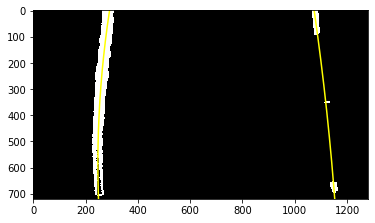

In [7]:
# Hitogram based methods

bottom_half_img = thresh_img[thresh_img.shape[0]//2:,:]
histogram = np.sum(bottom_half_img,axis=0)

# Starting points
mid_point_x = len(histogram)//2
left_box_centre_x = np.argmax(histogram[:mid_point_x])
right_box_centre_x = np.argmax(histogram[mid_point_x:])+mid_point_x

# Box params
num_box = 9
margin = 100
min_pixs = 50
box_height = thresh_img.shape[0]//num_box

# Empty array for indices
left_lane_x = []
left_lane_y = []
right_lane_x = []
right_lane_y = []

for n in range(num_box):
    left_box_x_min = left_box_centre_x - margin
    left_box_x_max = left_box_centre_x + margin
    right_box_x_min = right_box_centre_x - margin
    right_box_x_max = right_box_centre_x + margin
    box_y_min = thresh_img.shape[0] - ((n+1)*box_height)
    box_y_max = thresh_img.shape[0] - (n*box_height)
    
    # Note: x-rows and y-columns while using polyfit
    # Left lane indices
    non_zeros_left = thresh_img[box_y_min:box_y_max,left_box_x_min:left_box_x_max].nonzero()
    non_zeros_left_y = np.array(non_zeros_left[0]) + box_y_min
    non_zeros_left_x = np.array(non_zeros_left[1]) + left_box_x_min
    left_lane_x.append(non_zeros_left_y) # rows
    left_lane_y.append(non_zeros_left_x) # columns

    
    # Right lane indices
    non_zeros_right = thresh_img[box_y_min:box_y_max,right_box_x_min:right_box_x_max].nonzero()
    non_zeros_right_y = np.array(non_zeros_right[0]) + box_y_min
    non_zeros_right_x = np.array(non_zeros_right[1]) + right_box_x_min
    right_lane_x.append(non_zeros_right_y) # rows
    right_lane_y.append(non_zeros_right_x) # columns

    
    # Recenter left box
    if len(non_zeros_left_x) > min_pixs:
        left_box_centre_x = np.int(np.mean(non_zeros_left_x))
    if len(non_zeros_right_x) > min_pixs: 
        right_box_centre_x = np.int(np.mean(non_zeros_right_x))
        


# Make 1D array
leftx = np.concatenate(left_lane_x)
lefty = np.concatenate(left_lane_y)
rightx = np.concatenate(right_lane_x)
righty = np.concatenate(right_lane_y)


# Viz image
out_img = np.dstack((thresh_img, thresh_img, thresh_img))*255

# Fit left
left_fit = np.polyfit(leftx,lefty,2)
ploty = np.linspace(0, thresh_img.shape[0]-1, thresh_img.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]


# Fit right
right_fit = np.polyfit(rightx,righty,2)
ploty = np.linspace(0, thresh_img.shape[0]-1, thresh_img.shape[0])
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


plt.imshow(out_img)  
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
